<a href="https://colab.research.google.com/github/StudentHagal/Thesis/blob/main/Clustering_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Python Notebook, i will try to design ML model for PdM of Railway Vehicles using Clustering Algorithm to give label to dataset, and Classification Algorithm to predict out of sample data.

# ML Modelling Process

# 0) Preparation

## Loading Requirements

In [1]:
# Github repository
!git clone https://github.com/StudentHagal/Thesis.git

# Libraries
import sys
import pandas as pd
import hashlib
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import scipy
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#Extension
!pip install ipython-autotime
%load_ext autotime

print('Load completed')


Cloning into 'Thesis'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 139 (delta 47), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (139/139), 4.22 MiB | 3.70 MiB/s, done.
Resolving deltas: 100% (47/47), done.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Load completed
time: 1.31 ms (started: 2021-10-07 16:06:05 +00:00)


In [2]:
# Check the versions of libraries
# !!! WARNING !!!
# Important because model result may be different for other version
 
print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pd.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('joblib: {}'.format(joblib.__version__))

Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
sklearn: 0.22.2.post1
joblib: 1.0.1
time: 6 ms (started: 2021-10-07 16:06:05 +00:00)


## Define Functions and Variables

### Global Variables

In [3]:
#Global variables declaration
compare = '10f68054068bc4ac4d7fee65e8fd7a184151e3ce3abce5d85350fc13c412d93b'                         #known hash value of file
#Stored file path                     
raw_file = "/content/Thesis/Resources/database.csv"
#environment path
main_dir = '/content/Thesis/'           
model_dir = '/content/Thesis/Resources/models/'                                  
process_dir = '/content/Thesis/Resources/Processed/'
col_names = ['No', 'Datetime', 'Control_Mode', 'L1', 'L2', 'L3', 'Frequency', 'kVA_Total',           #Column names for dataset
             'kVA_L1', 'kVA_L2', 'kVA_L3', 'KVAr', 'Oil_Pressure', 'Coolant_Temp', 
             'Charger_Alternator', 'PF_Avg', 'PF_L1', 'PF_L2', 
             'PF_L3', 'L1_N', 'L2_N', 'L3_N', 'Source_Ext_Voltage', 'ECU_Temp', 
             'RPM', 'Train_code']
unused_col = ['No', 'Datetime', 'Control_Mode', 'L1', 'L2', 'L3', 'Frequency',                       #Unused columns in dataset
              'kVA_Total', 'kVA_L1', 'kVA_L2', 'kVA_L3', 'KVAr', 'Charger_Alternator',
              'RPM', 'PF_L1', 'PF_L2', 'PF_L3', 'L1_N','L2_N', 'L3_N',
              'Source_Ext_Voltage', 'Train_code']
dataset = pd.read_csv(raw_file, names=col_names)
val_results = []
names = []
# Algorithm considered
model_LR = LogisticRegression(max_iter=475)
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier()
model_SVM = SVC(gamma='auto')
model_RF = RandomForestClassifier()
model_LDA = LinearDiscriminantAnalysis()
model_NB = GaussianNB()
model_Kmeans = KMeans(n_clusters=3, random_state=0)
model_dbscan = DBSCAN(eps=0.5, min_samples=100)
balancing_smote = SMOTE(random_state=1)
###################################################################
models = []
models.append(('LR', model_LR))
models.append(('KNN', model_KNN))
models.append(('DT', model_DT))
models.append(('SVM', model_SVM))
models.append(('RF', model_RF))
models.append(('LDA', model_LDA))
models.append(('NB', model_NB))


time: 149 ms (started: 2021-10-07 16:06:05 +00:00)


### Hash Check Function

In [4]:
# Create function that returns the SHA-2 hash of the file
def hash_file(filepath):

   # make a hash object with SHA-2
   h = hashlib.sha256()

   # open file for reading in binary mode
   with open(filepath,'rb') as file:
       # loop till the end of the file
       chunk = 0
       while chunk != b'':
           # read only 1024 bytes at a time
           chunk = file.read(1024)
           h.update(chunk)

   # return the hex representation of digest
   return h.hexdigest()

time: 6.79 ms (started: 2021-10-07 16:06:05 +00:00)


### Show cluster result function

In [5]:
#Function to show cluster result
def show_clusters(dataset, labels):
  df = pd.DataFrame(dict(x=X_principal['P1'], y=X_principal['P2'], label=labels))
  colors = {-1:'black', 0:'blue', 1:'red', 2:'yellow' ,3:'green', 4:'orange'}
  fig, ax = plt.subplots(figsize=(8,8))
  grouped = df.groupby('label')
  for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.xlabel('X_1')
  plt.ylabel('X_2')
  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()


time: 10.8 ms (started: 2021-10-07 16:06:05 +00:00)


## 1) Standardized Dataset

### Checking Hash

In [6]:
message = hash_file(raw_file)
print('SHA-256 value of your file is :')
print(message)
if (compare == message) :
  print('Hash check SUCCESS')
else :
  print('Hash check INVALID')

SHA-256 value of your file is :
10f68054068bc4ac4d7fee65e8fd7a184151e3ce3abce5d85350fc13c412d93b
Hash check SUCCESS
time: 33.4 ms (started: 2021-10-07 16:06:05 +00:00)


### Processing dataset

In [7]:
# Dataset summary
pd.set_option('display.max_columns', None)      # Pandas display options
print('Total data size : ', dataset.shape)     # size of data (row, column)

Total data size :  (34357, 26)
time: 3.21 ms (started: 2021-10-07 16:06:05 +00:00)


In [8]:
dataset.head(5)                               # show sample entry

,No,Datetime,Control_Mode,L1,L2,L3,Frequency,kVA_Total,kVA_L1,kVA_L2,kVA_L3,KVAr,Oil_Pressure,Coolant_Temp,Charger_Alternator,PF_Avg,PF_L1,PF_L2,PF_L3,L1_N,L2_N,L3_N,Source_Ext_Voltage,ECU_Temp,RPM,Train_code
0,1.1,01-08-20 02:03,2.0,28.0,27.0,26.0,50.0,18.51,6.35,6.09,5.89,0.00,636.0,81.0,26.9,0.83,0.83,0.82,0.84,220.8,221.1,220.8,25.98,32767.0,1499.0,MP3-01605
1,1.2,01-08-20 03:00,2.0,39.0,39.0,37.0,50.0,25.74,8.65,8.45,8.24,0.00,636.0,81.0,26.9,0.76,0.77,0.75,0.77,220.8,220.5,220.8,25.84,32767.0,1501.0,MP3-01605
2,1.3,01-08-20 04:00,2.0,104.0,100.0,100.0,50.0,68.59,22.89,22.32,22.02,46.74,632.0,82.0,26.9,0.77,0.77,0.76,0.77,220.2,220.7,220.5,25.93,32767.0,1499.0,MP3-01605
3,1.4,01-08-20 05:00,2.0,90.0,87.0,87.0,50.0,59.36,19.81,19.30,19.15,39.78,632.0,82.0,26.9,0.78,0.78,0.77,0.78,220.5,220.5,220.8,26.18,32767.0,1500.0,MP3-01605
4,1.5,01-08-20 06:00,2.0,98.0,96.0,96.0,50.0,64.60,21.66,21.14,21.14,43.31,628.0,82.0,27.0,0.78,0.77,0.78,0.78,220.3,220.4,220.6,26.14,32767.0,1500.0,MP3-01605


time: 40.1 ms (started: 2021-10-07 16:06:05 +00:00)


In [9]:
dataset.info()                                 # concise information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34357 entries, 0 to 34356
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   No                  33832 non-null  float64
 1   Datetime            33832 non-null  object 
 2   Control_Mode        33832 non-null  float64
 3   L1                  33832 non-null  float64
 4   L2                  33832 non-null  float64
 5   L3                  33832 non-null  float64
 6   Frequency           33832 non-null  float64
 7   kVA_Total           33832 non-null  float64
 8   kVA_L1              33832 non-null  float64
 9   kVA_L2              33832 non-null  float64
 10  kVA_L3              33832 non-null  float64
 11  KVAr                33832 non-null  float64
 12  Oil_Pressure        33832 non-null  float64
 13  Coolant_Temp        33832 non-null  float64
 14  Charger_Alternator  33832 non-null  float64
 15  PF_Avg              33832 non-null  float64
 16  PF_L

In [10]:
dataset.groupby('Train_code').size()   # class distribution

Train_code
MP3-01605    1434
MP3-01606     983
P-01601       423
P-01801      1922
P-01808      3068
P-01810      2570
P-01811      2258
P-01812      1231
P-01818      2280
P-01820      2186
P-01821      2006
P-01822      2901
P-01823       867
P-01825      1396
P-01903      2128
P-01908      3187
P-01914      2992
dtype: int64

time: 11.7 ms (started: 2021-10-07 16:06:05 +00:00)


In [11]:
dataset.describe()                      # statistical value of data

,No,Control_Mode,L1,L2,L3,Frequency,kVA_Total,kVA_L1,kVA_L2,kVA_L3,KVAr,Oil_Pressure,Coolant_Temp,Charger_Alternator,PF_Avg,PF_L1,PF_L2,PF_L3,L1_N,L2_N,L3_N,Source_Ext_Voltage,ECU_Temp,RPM
count,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,3.383200e+04,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000
mean,16.382906,1.531893,104.661208,103.481822,103.836072,41.849285,69.517004,23.098147,22.853998,22.919337,2.567771e+04,1533.996364,663.118379,23.126040,5.953150,5.577243,5.935014,6.347120,186.349900,186.401478,186.174010,23.340322,6278.678647,1345.971831
std,9.070813,0.810421,79.092619,78.685596,78.725843,18.329195,52.483808,17.573883,17.497579,17.482340,3.308827e+05,8092.570600,4389.881127,10.263944,40.234364,39.608321,41.013527,42.585116,80.731685,80.867993,80.890586,9.010295,12862.110888,2602.133855
min,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.200000,1.000000,39.000000,38.000000,38.000000,50.000000,26.037500,8.440000,8.280000,8.260000,9.680000e+00,592.000000,76.000000,27.100000,0.780000,0.780000,0.780000,0.780000,219.600000,219.700000,219.675000,26.330000,36.000000,1499.000000
50%,16.900000,2.000000,104.000000,103.000000,103.000000,50.000000,69.020000,22.985000,22.725000,22.940000,3.354000e+01,612.000000,81.000000,27.700000,0.870000,0.870000,0.860000,0.860000,221.100000,221.300000,221.100000,27.110000,41.000000,1499.000000
75%,24.360000,2.000000,159.000000,157.000000,157.000000,50.000000,105.420000,35.160000,34.700000,34.680000,5.388000e+01,624.000000,82.000000,27.900000,0.890000,0.890000,0.890000,0.880000,222.200000,222.400000,222.300000,27.300000,48.000000,1500.000000
max,31.990000,5.000000,555.000000,562.000000,557.000000,51.900000,376.510000,125.340000,127.240000,125.700000,4.294967e+06,65535.000000,65531.000000,29.900000,327.650000,327.650000,327.650000,327.650000,227.800000,227.900000,229.100000,30.720000,32767.000000,65531.000000


time: 112 ms (started: 2021-10-07 16:06:05 +00:00)


## 2) Feature Engineering

### Feature Selection

In [12]:
# Process dataset to obtain usable features
# delete columns with condition
dataset.drop(labels=unused_col, axis=1, inplace=True)
dataset

,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp
0,636.0,81.0,0.83,32767.0
1,636.0,81.0,0.76,32767.0
2,632.0,82.0,0.77,32767.0
3,632.0,82.0,0.78,32767.0
4,628.0,82.0,0.78,32767.0
...,...,...,...,...
34352,600.0,83.0,0.88,32767.0
34353,604.0,82.0,0.88,32767.0
34354,604.0,81.0,0.87,32767.0
34355,0.0,0.0,0.00,0.0


time: 18.8 ms (started: 2021-10-07 16:06:05 +00:00)


In [13]:
dataset.describe()     # statistical value of data

,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp
count,33832.000000,33832.000000,33832.000000,33832.000000
mean,1533.996364,663.118379,5.953150,6278.678647
std,8092.570600,4389.881127,40.234364,12862.110888
min,0.000000,0.000000,0.000000,0.000000
25%,592.000000,76.000000,0.780000,36.000000
50%,612.000000,81.000000,0.870000,41.000000
75%,624.000000,82.000000,0.890000,48.000000
max,65535.000000,65531.000000,327.650000,32767.000000


time: 28.4 ms (started: 2021-10-07 16:06:05 +00:00)


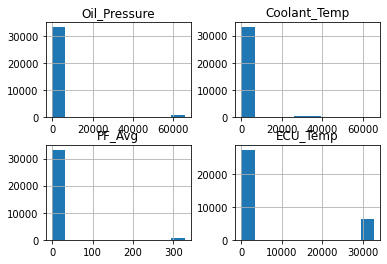

time: 548 ms (started: 2021-10-07 16:06:05 +00:00)


In [14]:
dataset.hist()                # Visualize data using histograms
pyplot.show()

### Data Labelling
Data labelling using Clustering Algorithm


In [15]:
# Pre-process data
dataset.fillna(method ='ffill', inplace = True)           #fill any missing values
dataset.drop_duplicates()                       
X_scaled = StandardScaler().fit_transform(dataset)        #Bring all the attributes to a comparable level
X_normalized = normalize(X_scaled)                        #Making the data approximately follows a Gaussian distribution
X_normalized = pd.DataFrame(X_normalized)                 #Converting the numpy array into a pandas DataFrame

X_normalized.head(10)

,0,1,2,3
0,-0.053887,-0.064232,-0.061986,0.994549
1,-0.053884,-0.064228,-0.062816,0.994498
2,-0.054122,-0.064119,-0.062697,0.994499
3,-0.054122,-0.064119,-0.062579,0.994507
4,-0.054359,-0.064118,-0.062578,0.994494
5,-0.054360,-0.064119,-0.062341,0.994509
6,-0.054834,-0.064118,-0.062102,0.994498
7,-0.055071,-0.064117,-0.062219,0.994477
8,-0.054834,-0.064118,-0.062102,0.994498
9,-0.055072,-0.064009,-0.061864,0.994506


time: 28.8 ms (started: 2021-10-07 16:06:06 +00:00)


         P1        P2
0  1.565863 -0.120209
1  1.565702 -0.120623
2  1.565705 -0.120640
3  1.565728 -0.120581
4  1.565687 -0.120718
5  1.565733 -0.120600
6  1.565697 -0.120756
7  1.565633 -0.120953
8  1.565697 -0.120756
9  1.565723 -0.120714


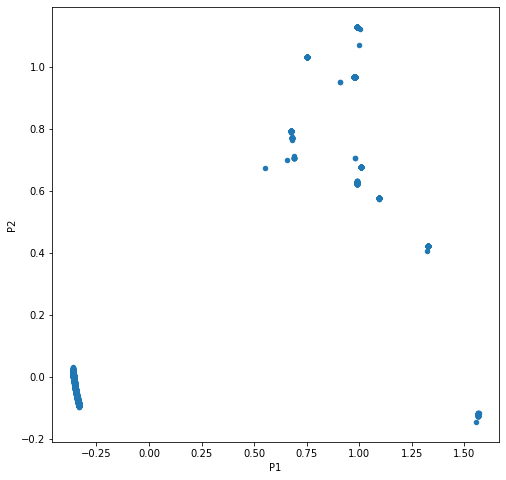

time: 476 ms (started: 2021-10-07 16:06:06 +00:00)


In [16]:
#reduce dimension for easier visualization
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

# Scatter plot data
print(X_principal.head(10))
df = pd.DataFrame(dict(x=X_principal['P1'], y=X_principal['P2']))
fig, ax = plt.subplots(figsize=(8,8))
df.plot(ax=ax, kind='scatter', x='x', y='y')
plt.xlabel('P1')
plt.ylabel('P2')
plt.show()


In [17]:
# Build DBSCAN Model
model_dbscan.fit(X_principal)
labels_dbscan = model_dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print('Estimated number of dbscan clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of dbscan clusters: 3
Estimated number of noise points: 0
time: 15.9 s (started: 2021-10-07 16:06:06 +00:00)


In [18]:
# Build K means model
model_Kmeans.fit(X_principal)
labels_Kmeans = model_Kmeans.labels_

print('Estimated number of kmeans clusters: ')
print(len(set(labels_dbscan)))

Estimated number of kmeans clusters: 
3
time: 180 ms (started: 2021-10-07 16:06:22 +00:00)


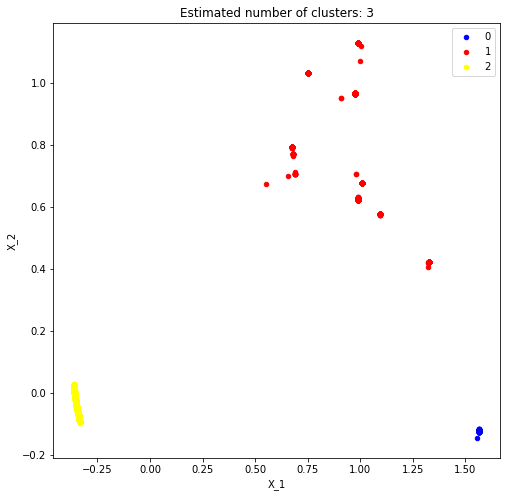

time: 512 ms (started: 2021-10-07 16:06:22 +00:00)


In [19]:
# cluster result from DBSCAN
show_clusters(dataset, labels_dbscan)

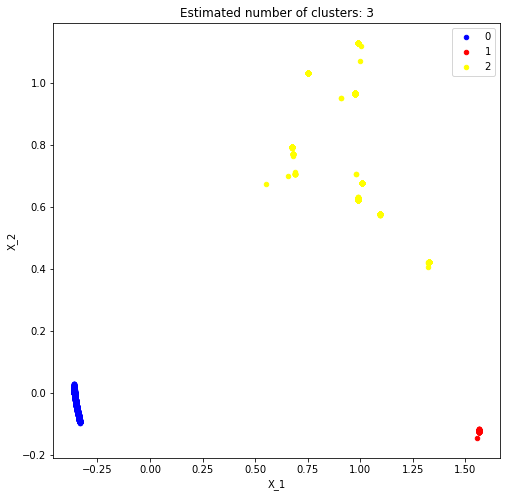

time: 476 ms (started: 2021-10-07 16:06:23 +00:00)


In [20]:
# cluster result from K-Means
show_clusters(dataset, labels_Kmeans)

In [21]:
# add predicted label into dataframe
dfx = pd.DataFrame(X_principal)
dfx['clusters_dbscan'] = labels_dbscan
dfx['clusters_kmeans'] = labels_Kmeans
dfx.groupby('clusters_dbscan').size()

# Cluster assumption:
# 0 is Normal
# 1 is Maintenance
# 2 is Outlier

clusters_dbscan
0     5475
1     1288
2    27594
dtype: int64

time: 17 ms (started: 2021-10-07 16:06:23 +00:00)


In [22]:
dfx.groupby('clusters_kmeans').size()

# Cluster assumption:
# 0 is Outlier
# 1 is Normal
# 2 is Maintenance

clusters_kmeans
0    27594
1     5475
2     1288
dtype: int64

time: 9.2 ms (started: 2021-10-07 16:06:23 +00:00)


In [23]:
# !!! WARNING !!!
# Only choose either DBSCAN or Kmeans to be used as the basis for the label
# Running with both active will return the last value computed

# Export chosen label (DBSCAN) into external file
dataset['clusters'] = labels_dbscan
dataset.to_csv(process_dir+'output_dbscan.csv')
dataset.groupby('clusters').size()

clusters
0     5475
1     1288
2    27594
dtype: int64

time: 188 ms (started: 2021-10-07 16:06:23 +00:00)


In [24]:
# !!! WARNING !!!
# Only choose either DBSCAN or Kmeans to be used as the basis for the label
# Running with both active will return the last value computed

# Export chosen label (Kmeans) into external file
#dataset['clusters'] = labels_Kmeans
#dataset.to_csv(process_dir+'output_kmeans.csv')
#dataset.groupby('clusters').size()

time: 2.38 ms (started: 2021-10-07 16:06:24 +00:00)


## 3) Algorithm Selection
Differ for each iteration, by default all consideration will be selected to build ML model. But after the best choice is identified, there may be only a few algorithm to be selected.

Algorithm considered:
LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC(), RandomForestClassifier(), LinearDiscriminantAnalysis(), GaussianNB()

## 4) Data Pre Processing

In [25]:
#Visualize dataset
dataset

,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp,clusters
0,636.0,81.0,0.83,32767.0,0
1,636.0,81.0,0.76,32767.0,0
2,632.0,82.0,0.77,32767.0,0
3,632.0,82.0,0.78,32767.0,0
4,628.0,82.0,0.78,32767.0,0
...,...,...,...,...,...
34352,600.0,83.0,0.88,32767.0,0
34353,604.0,82.0,0.88,32767.0,0
34354,604.0,81.0,0.87,32767.0,0
34355,0.0,0.0,0.00,0.0,2


time: 21.7 ms (started: 2021-10-07 16:06:24 +00:00)


In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34357 entries, 0 to 34356
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Oil_Pressure  34357 non-null  float64
 1   Coolant_Temp  34357 non-null  float64
 2   PF_Avg        34357 non-null  float64
 3   ECU_Temp      34357 non-null  float64
 4   clusters      34357 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.3 MB
time: 12.9 ms (started: 2021-10-07 16:06:24 +00:00)


In [27]:
print(dataset.groupby('clusters').size())

clusters
0     5475
1     1288
2    27594
dtype: int64
time: 6.67 ms (started: 2021-10-07 16:06:24 +00:00)


In [28]:
dataset.describe()

,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp,clusters
count,34357.000000,34357.000000,34357.000000,34357.000000,34357.000000
mean,1543.489333,666.242309,6.032283,6281.289664,1.643799
std,8134.961167,4401.363219,40.541743,12864.273629,0.740304
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,592.000000,76.000000,0.780000,36.000000,2.000000
50%,612.000000,81.000000,0.860000,41.000000,2.000000
75%,624.000000,82.000000,0.890000,48.000000,2.000000
max,65535.000000,65531.000000,327.650000,32767.000000,2.000000


time: 32.2 ms (started: 2021-10-07 16:06:24 +00:00)


### Pre-Processing

In [29]:
#resample to balance data
array = dataset.values
X = array[:,0:4]
y = array[:,4]

print('Original dataset shape %s' % Counter(y))
X_res, y_res = balancing_smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2.0: 27594, 0.0: 5475, 1.0: 1288})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0.0: 27594, 1.0: 27594, 2.0: 27594})
time: 440 ms (started: 2021-10-07 16:06:24 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Split Data


In [30]:
# Split-out training and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.20, 
                                                    random_state=1)

print('training data size = ', X_train.shape)
print('testing data size = ', X_test.shape)
print('data split completed')

training data size =  (66225, 4)
testing data size =  (16557, 4)
data split completed
time: 18.4 ms (started: 2021-10-07 16:06:24 +00:00)


In [31]:
#Training data summary
dfx_train = pd.DataFrame(X_train)
dfx_train.describe()

,0,1,2,3
count,66225.000000,66225.000000,66225.000000,66225.000000
mean,9748.898812,5444.535327,48.197808,20203.741620
std,22663.976666,12132.321150,112.452875,15918.366438
min,0.000000,0.000000,0.000000,0.000000
25%,596.000000,80.000000,0.810000,41.456086
50%,612.000000,82.000000,0.880000,32767.000000
75%,632.000000,83.000000,0.910000,32767.000000
max,65535.000000,65531.000000,327.650000,32767.000000


time: 39.2 ms (started: 2021-10-07 16:06:24 +00:00)


In [32]:
#Test data summary
dfx_test = pd.DataFrame(X_test)
dfx_test.describe()

,0,1,2,3
count,16557.00000,16557.000000,16557.000000,16557.000000
mean,9664.57096,5243.114204,48.659352,19908.387911
std,22576.82142,11954.193437,112.995266,15986.339830
min,0.00000,0.000000,0.000000,0.000000
25%,596.00000,80.000000,0.810000,41.000000
50%,612.00000,82.000000,0.880000,32767.000000
75%,632.00000,83.000000,0.910000,32767.000000
max,65535.00000,65531.000000,327.650000,32767.000000


time: 29 ms (started: 2021-10-07 16:06:24 +00:00)


## 5) Algorithm Training & Validation

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 1.000000 (0.000000)
KNN: 1.000000 (0.000000)
DT: 1.000000 (0.000000)
SVM: 0.996391 (0.001007)
RF: 1.000000 (0.000000)
LDA: 0.950804 (0.002279)
NB: 0.998671 (0.000495)


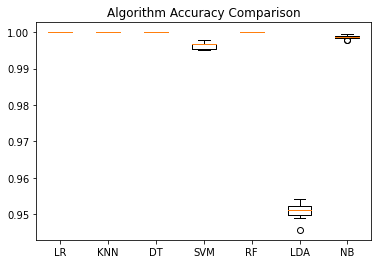

time: 19min 59s (started: 2021-10-07 16:06:24 +00:00)


In [33]:
# Cross validation of each model training in turn
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	val_results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare result
pyplot.boxplot(val_results, labels=names)
pyplot.title('Algorithm Accuracy Comparison')
pyplot.show()

In [34]:
# Re-train each algorithm using whole training dataset for better model
# Each model is separated in different code block for easier tracking of Runtime
model_LR.fit(X_train, Y_train)
joblib.dump(model_LR, model_dir+'Opsi3_LR.joblib')

['/content/Thesis/Resources/models/Opsi3_LR.joblib']

time: 24.8 s (started: 2021-10-07 16:26:24 +00:00)


In [35]:
model_KNN.fit(X_train, Y_train)
joblib.dump(model_KNN,model_dir+'Opsi3_KNN.joblib')

['/content/Thesis/Resources/models/Opsi3_KNN.joblib']

time: 403 ms (started: 2021-10-07 16:26:49 +00:00)


In [36]:
model_DT.fit(X_train, Y_train)
joblib.dump(model_DT,model_dir+'Opsi3_DT.joblib')

['/content/Thesis/Resources/models/Opsi3_DT.joblib']

time: 52.4 ms (started: 2021-10-07 16:26:49 +00:00)


In [37]:
model_SVM.fit(X_train, Y_train)
joblib.dump(model_SVM,model_dir+'Opsi3_SVM.joblib')

['/content/Thesis/Resources/models/Opsi3_SVM.joblib']

time: 1min 44s (started: 2021-10-07 16:26:49 +00:00)


In [38]:
model_RF.fit(X_train, Y_train)
joblib.dump(model_RF,model_dir+'Opsi3_RF.joblib')

['/content/Thesis/Resources/models/Opsi3_RF.joblib']

time: 2.75 s (started: 2021-10-07 16:28:34 +00:00)


In [39]:
model_LDA.fit(X_train, Y_train)
joblib.dump(model_LDA,model_dir+'Opsi3_LDA.joblib')

['/content/Thesis/Resources/models/Opsi3_LDA.joblib']

time: 63.1 ms (started: 2021-10-07 16:28:36 +00:00)


In [40]:
model_NB.fit(X_train, Y_train)
joblib.dump(model_NB,model_dir+'Opsi3_NB.joblib')

['/content/Thesis/Resources/models/Opsi3_NB.joblib']

time: 35.1 ms (started: 2021-10-07 16:28:36 +00:00)


In [41]:
print('Model training completed!')

Model training completed!
time: 5.8 ms (started: 2021-10-07 16:28:36 +00:00)


# ML Model Evaluation Process
Ada dua evaluasi yang akan dilakukan, pertama akan dievaluasi untuk mengecek kemungkinan untuk mendapatkan hasil yang lebih baik, kedua yaitu mengevaluasi hasil yang didapatkan untuk menentukan kesuksesan model ML dengan target sukses yang ditentukan. Target sukses berdasarkan dua kriteria, Akurasi minimal 90% dan Runtime maksimal 15 menit.

## 1) ML Model Testing
Pada tahap ini, akan digunakan test dataset untuk menguji performa model ML dengan data yang diketahui labelnya, namun disembunyikan saat pengujian. Dengan demikian dapat diketahui nilai Accuracy, Precision, Recall serta F1-Score untuk dibandingkan dengan hasil training. Jika hasilnya konsisten, atau tidak terlalu menyimpang jauh dengan nilai Akurasi dari hasil training model, maka model ML telah tervalidasi bahwa model dapat digunakan untuk prediksi.

LR Result:
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      5453
         2.0       1.00      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



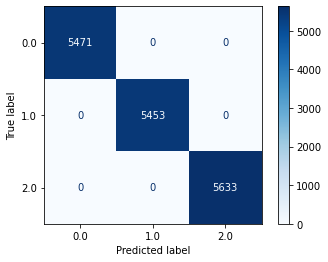

time: 252 ms (started: 2021-10-07 16:28:36 +00:00)


In [42]:
# Test each model using testing dataset for evaluation of accuracy
# Each model is separated in different code block for easier tracking of Runtime
pred_LR = model_LR.predict(X_test)

print('LR Result:')
print(accuracy_score(Y_test, pred_LR))
print(classification_report(Y_test, pred_LR))
plot_confusion_matrix(model_LR, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

KNN Result:
0.9999396025850094
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      5453
         2.0       1.00      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



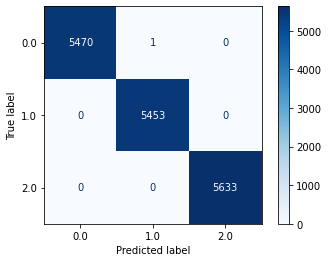

time: 1.91 s (started: 2021-10-07 16:28:37 +00:00)


In [43]:
pred_KNN = model_KNN.predict(X_test)

print('KNN Result:')
print(accuracy_score(Y_test, pred_KNN))
print(classification_report(Y_test, pred_KNN))
plot_confusion_matrix(model_KNN, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

DT Result:
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      5453
         2.0       1.00      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



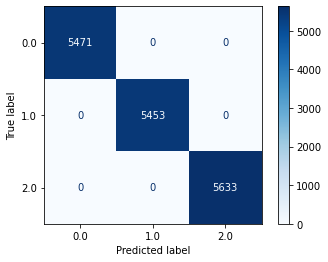

time: 227 ms (started: 2021-10-07 16:28:39 +00:00)


In [44]:
pred_DT = model_DT.predict(X_test)

print('DT Result:')
print(accuracy_score(Y_test, pred_DT))
print(classification_report(Y_test, pred_DT))
plot_confusion_matrix(model_DT, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

SVM Result:
0.9972821163254213
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      0.99      1.00      5453
         2.0       0.99      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



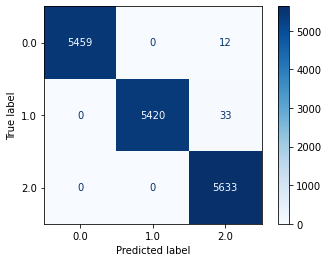

time: 5.82 s (started: 2021-10-07 16:28:39 +00:00)


In [45]:
pred_SVM = model_SVM.predict(X_test)

print('SVM Result:')
print(accuracy_score(Y_test, pred_SVM))
print(classification_report(Y_test, pred_SVM))
plot_confusion_matrix(model_SVM, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

RF Result:
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      5453
         2.0       1.00      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



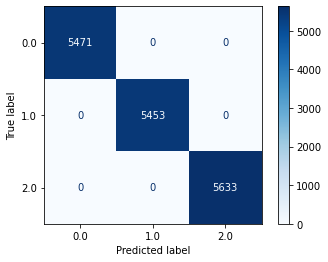

time: 487 ms (started: 2021-10-07 16:28:45 +00:00)


In [46]:
pred_RF = model_RF.predict(X_test)

print('RF Result:')
print(accuracy_score(Y_test, pred_RF))
print(classification_report(Y_test, pred_RF))
plot_confusion_matrix(model_RF, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

LDA Result:
0.9521652473274144
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5471
         1.0       1.00      0.85      0.92      5453
         2.0       0.90      1.00      0.95      5633

    accuracy                           0.95     16557
   macro avg       0.96      0.95      0.95     16557
weighted avg       0.96      0.95      0.95     16557



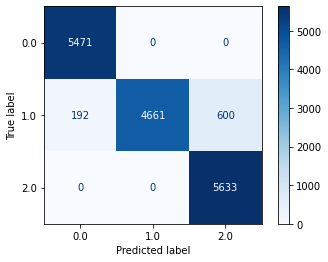

time: 236 ms (started: 2021-10-07 16:28:45 +00:00)


In [47]:
pred_LDA = model_LDA.predict(X_test)

print('LDA Result:')
print(accuracy_score(Y_test, pred_LDA))
print(classification_report(Y_test, pred_LDA))
plot_confusion_matrix(model_LDA, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()

NB Result:
0.9983692697952528
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      5453
         2.0       1.00      1.00      1.00      5633

    accuracy                           1.00     16557
   macro avg       1.00      1.00      1.00     16557
weighted avg       1.00      1.00      1.00     16557



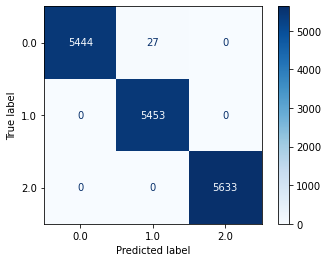

time: 239 ms (started: 2021-10-07 16:28:45 +00:00)


In [48]:
pred_NB = model_NB.predict(X_test)

print('NB Result:')
print(accuracy_score(Y_test, pred_NB))
print(classification_report(Y_test, pred_NB))
plot_confusion_matrix(model_NB, X_test, Y_test, values_format='d', cmap=plt.cm.Blues)
plt.show()